In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import math

In [4]:

start = datetime.datetime(2017, 1, 1)
end = datetime.datetime(2021, 2, 19)


companies = pd.read_csv('nasdaq_screener_1613925401786.csv')

Symbols = [row['Symbol']
           for index, row in companies.iterrows() if row['Market Cap'] > 1e9]

In [5]:
stock_final = pd.DataFrame()
# iterate over each symbol
for i in Symbols:

    # print the symbol which is being downloaded
    try:
        # download the stock price
        stock = []
        stock = yf.download(i, start=start, end=end, progress=False)

        # append the individual stock prices
        if len(stock) == 0:
            None
        else:
            stock['Name'] = i
            stock_final = stock_final.append(stock, sort=False)
    except Exception:
        None


1 Failed download:
- OTTR: No data found for this date range, symbol may be delisted


In [6]:
stock_final = stock_final[['Name','Close']]

In [9]:
stock_final.to_csv (r'stock_dataframe.csv', index = False)

In [7]:
stock_final.head()

,Name,Close
Date,,
2020-09-04,AACQ,10.00
2020-09-08,AACQ,9.95
2020-09-09,AACQ,9.99
2020-09-10,AACQ,9.96
2020-09-11,AACQ,9.96


In [6]:
stock_final = pd.read_csv('/Users/michaelhyh/ProjectData/GitHub/blueprint-2021/load_stock_symbols/stock_dataframe.csv')

In [7]:
prevName = ''
count = -1
data_list = []
for index, row in stock_final.iterrows():
    if row['Name'] != prevName:
        count += 1
        data_list.append([])
        prevName = row['Name']
    if not math.isnan(row['Close']):
        data_list[count].append(row['Close'])

In [8]:
def toDataset(arr, window_size=30):
    final_ds = None
    for row in arr:
        r_arr = np.array(row)
        series = tf.expand_dims(r_arr,-1)
        ds = tf.data.Dataset.from_tensor_slices(series)
        ds = ds.window(window_size+1,shift=window_size,drop_remainder=True)
        ds = ds.flat_map(lambda window: window.batch(window_size+1))
        for window in ds.as_numpy_iterator():
            window = (window-np.mean(window))/np.std(window)
        ds = ds.map(lambda window: (window[:-1], window[1:]))
        if final_ds:
            final_ds = final_ds.concatenate(ds)
        else:
            final_ds = ds
    print(final_ds.element_spec)
    return final_ds.batch(128).prefetch(1)

In [9]:
train_ds = toDataset(data_list[:1000])
val_ds = toDataset(data_list[1000:])

(TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))
(TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))


In [10]:
in_batch, out_batch = tf.data.experimental.get_single_element(train_ds.take(1))
print(in_batch)

In [60]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(64,return_sequences=True,input_shape=[30,1]),
    tf.keras.layers.Dense(1)
])

In [61]:
model.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=1),loss=tf.keras.losses.Huber(),metrics=['mse'])

In [62]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_13 (SimpleRNN)    (None, 30, 64)            4224      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 1)             65        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.fit(train_ds, epochs=20,validation_data=val_ds,callbacks=[tf.keras.callbacks.ModelCheckpoint(
    "model.h5", save_best_only=True)])

Epoch 1/20
218/218 [==============================] - 28s 122ms/step - loss: 0.0307 - mse: 0.0640 - val_loss: 0.0066 - val_mse: 0.0133
Epoch 2/20
218/218 [==============================] - 26s 119ms/step - loss: 0.0074 - mse: 0.0154 - val_loss: 0.0064 - val_mse: 0.0129
Epoch 3/20
218/218 [==============================] - 27s 122ms/step - loss: 0.0073 - mse: 0.0151 - val_loss: 0.0064 - val_mse: 0.0129
Epoch 4/20
218/218 [==============================] - 26s 120ms/step - loss: 0.0073 - mse: 0.0150 - val_loss: 0.0063 - val_mse: 0.0128
Epoch 5/20
218/218 [==============================] - 27s 123ms/step - loss: 0.0072 - mse: 0.0150 - val_loss: 0.0063 - val_mse: 0.0128
Epoch 6/20
218/218 [==============================] - 26s 120ms/step - loss: 0.0072 - mse: 0.0149 - val_loss: 0.0063 - val_mse: 0.0127
Epoch 7/20
218/218 [==============================] - 26s 118ms/step - loss: 0.0072 - mse: 0.0149 - val_loss: 0.0063 - val_mse: 0.0127
Epoch 8/20
218/218 [==============================] - 2

In [64]:
new_ds = train_ds.take(1)
print(new_ds.element_spec)

(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


In [65]:
result = model.predict(new_ds)
print(result.shape)

(128, 30, 1)


Text(0, 0.5, 'price')

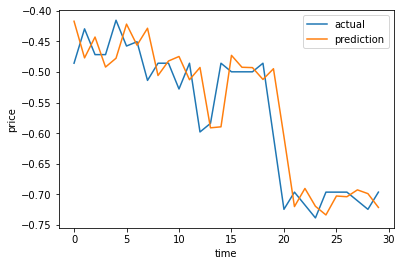

In [67]:
import matplotlib.pyplot as plt
list_in = new_ds.as_numpy_iterator()
list_in = next(list_in)[1]
list_in = list_in[0]
list_giv = [val[0] for val in list_in]
list_out = result[0]
list_pre = [val[0] for val in list_out]
plt.plot(range(len(list_giv)), list_giv, label='actual')
plt.plot(range(len(list_pre)),list_pre, label='prediction')
plt.legend()
plt.xlabel('time')
plt.ylabel('price')

